In [1]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
import sklearn.model_selection as model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

In [2]:
data = pd.read_csv("Data_comp.csv")

X = data.drop(['Image', 'Category'], axis = 1)
y = data['Category']

# Divide data into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

In [3]:
print(f"Dimensions of the X train: {X_train.shape}")
print(f"Dimensions of the X test: {X_test.shape}")
print(f"Dimensions of the Y train: {y_train.shape}")
print(f"Dimensions of the Y test: {y_test.shape}")

Dimensions of the X train: (2611, 14)
Dimensions of the X test: (653, 14)
Dimensions of the Y train: (2611,)
Dimensions of the Y test: (653,)


In [4]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Coding Labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Show the classes and their coded labels
for index, label in enumerate(encoder.classes_):
    print(f"Class {index}: {label}")

Class 0: glioma_tumor
Class 1: meningioma_tumor
Class 2: no_tumor
Class 3: pituitary_tumor


In [5]:
# SFeature Selection
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_encoded)
X_test_selected = selector.transform(X_test_scaled)

In [6]:
feature_names = X_train.columns

# Get the indexes of the selected characteristics
selected_indices = selector.get_support(indices=True)
selected_features = feature_names[selected_indices]

i = 0
print("Selected features:")
for feature in selected_features:
    i += 1
    print(f"Feature {i}: {feature}")

Selected features:
Feature 1: Contrast
Feature 2: Dissimilarity
Feature 3: Homogeneity
Feature 4: ASM
Feature 5: Energy
Feature 6: Correlation
Feature 7: Entropy
Feature 8: Gabor
Feature 9: HOG
Feature 10: LBP


In [7]:
# Hyperparameter setting
params_grid = {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance']}

In [8]:
# Stratified cross-validation
cv = StratifiedKFold(n_splits=10)

In [9]:
# Create and train the model
knn_model = GridSearchCV(KNeighborsClassifier(), params_grid, cv=cv)
knn_model.fit(X_train_selected, y_train_encoded)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']})

In [10]:
# Predicting labels for the test set
y_pred = knn_model.predict(X_test_selected)

In [11]:
# Calculate and display confusion matrix and ranking report
cm = confusion_matrix(y_test_encoded, y_pred)
print(cm)

print(classification_report(y_test_encoded, y_pred))

[[131  45   2  22]
 [ 40 135   4  10]
 [  2  12  77   5]
 [ 10   8   1 149]]
              precision    recall  f1-score   support

           0       0.72      0.66      0.68       200
           1       0.68      0.71      0.69       189
           2       0.92      0.80      0.86        96
           3       0.80      0.89      0.84       168

    accuracy                           0.75       653
   macro avg       0.78      0.76      0.77       653
weighted avg       0.76      0.75      0.75       653



[Text(0, 0.5, 'Class 0'),
 Text(0, 1.5, 'Class 1'),
 Text(0, 2.5, 'Class 2'),
 Text(0, 3.5, 'Class 3')]

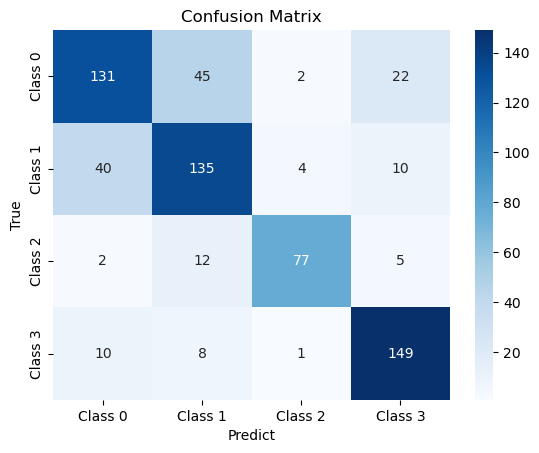

In [12]:
# Creating a figure and a set of subplots
fig, ax = plt.subplots()

# Create a heat map
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')

# Labels, títles and ticks
ax.set_xlabel('Predict')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])
ax.yaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Save Figure
#plt.savefig('confusion_matrix_KNN.jpg', dpi=600)

In [13]:
# Converting labels to two-dimensional arrays
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])
y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2, 3])

# Calculate and display ROC-AUC score
roc_auc = roc_auc_score(y_test_binarized, y_pred_binarized, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.8393176663628262


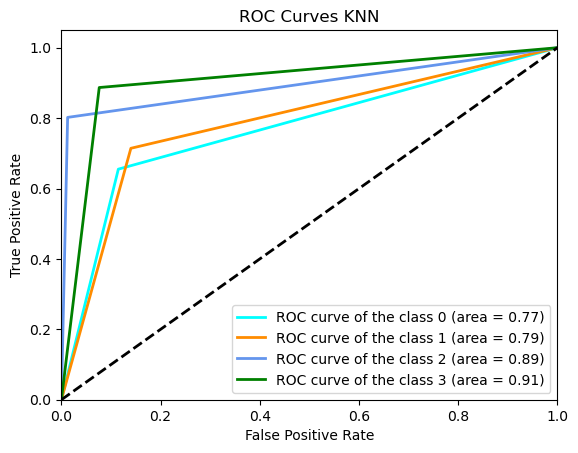

In [14]:
# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of the class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves KNN')
plt.legend(loc="lower right")

# Save Figure
#plt.savefig('roc_curves_KNN.jpg', dpi=600)
plt.show()

In [15]:
# Print the best parameters
print("Best parameters: ", knn_model.best_params_)

Best parameters:  {'n_neighbors': 4, 'weights': 'distance'}
